In [1]:
import numpy as np
import stat as st
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import scipy.stats as scs
import matplotlib.pyplot as plt
import math
from pandas.tools.plotting import autocorrelation_plot
from pandas import read_csv, DataFrame
from sklearn.metrics import r2_score
import datetime
import copy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Функции

In [2]:
df = pd.read_csv('gold_day_2_year.csv', sep=';', keep_default_na=False)
data = df.cost

In [70]:
def stat(x):
    _x = x  # Для возможности предобработки данных (например, исключения нечисловых значений) 
    print('счет', len(x))
    print('среднее', (np.mean(_x)))
    print('минимальное', np.min(_x), 'и максимальное', np.max(_x))
    print('стандартное отклонение', pd.core.groupby.GroupBy.std(_x))
    print('дисперсия', np.var(_x))
    print('коэффициент вариации', (np.std(_x)) / (np.mean(_x)))
    print('коэффициент асимметрии', scs.skew(_x))  # асимметрия 
    print('эксцесс', scs.kurtosis(_x)) # эксцесс


def student(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Критерий Стьюдента для двух выборок
    # Нулевая гипотеза: мат ожидания для двух групп равны
    # Причём должно выполнится предположение о равной дисперсии
    # (способы проверки которого приведены ниже)
    # Это верно для независимых групп: например, результаты экзамена для мальчиков и девочек
    # И для зависимых групп: например, как один и тот же класс сдал 2 разных экзамена.
    t_statistic, p_value = scs.ttest_ind(group1, group2)
 
    # p_value &lt; 0.05 =&gt; альтернативная гипотеза:
    # с 5% вероятностью ошибки первого рода у нас будет разное мат. ожидание
    # тест с 2 хвостами, двухпарный
    print("two-sample t-test:")
    print('p_value =', p_value)
    print('t_statistic =', t_statistic)


def student2(data):
    r = 0
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) != np.var(group2):
        t = (abs(np.mean(group1) - np.mean(group2))) / math.sqrt(
            (np.var(group1) / len(group1) + np.var(group2) / len(group2)))
        print('дисперсии не равны')
        print('критерий Стьюдента =', t)
    else:
        t = ((abs(np.mean(group1) - np.mean(group2))) / np.var(group2)) * (math.sqrt(
            (len(group1) * len(group2)) / (len(group1) + len(group2))))
        print('дисперсии равны')
        print('критерий Стьюдента =', t)


def mann2(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Если данные не распределены нормально, применяем критерий Манна-Уитни, также известный как 
    # Критерий Уилкоксона для двух выборок
    u, p_value = scs.mannwhitneyu(group1, group2, alternative='two-sided')
    g1 = len(group1)
    g2 = len(group2)
    print('two-sample wilcoxon-test(mann-whitneyu), p_value =', p_value)
    print('U =', u)
    print('M(U) =', g1 * g2 / 2)
    print('D(U) =', g1 * g2 * (g1 + g2 + 1) / 12)
    if (u - (g1 * g2 / 2)) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12) > 0:
        z = (u - (g1 * g2 / 2) - 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    else:
        z = (u - (g1 * g2 / 2) + 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    print('Z =', z)


def fisher(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) >= np.var(group2):
        f = np.var(group1) / np.var(group2)
    else:
        f = np.var(group2) / np.var(group1)
    print('критерий Фишера =', f)


def acf_and_pacf(data, lags=None):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()


def mann(x):
    x = list(x)
    s = [0] * len(x)
    for i in range(len(x)):
        s[i] = i + 1
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    u1 = r1 - (t1 * (t1 + 1)) / 2
    u2 = t1 * t2 - (t2 * ( t2 + 1)) / 2 - r2
    mu = (t1 * t2) / 2
    du = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (u1 - (t1 * t2) / 2) / (sqrt(du))
    if z > 0:
        z = (u1 - (t1 * t2) / 2 - 1 / 2) / (sqrt(du))
    else:
        z = (u1 - (t1 * t2) / 2 + 1 / 2) / (sqrt(du))
    print('U =', u1)
    print('M(U) =', mu)
    print('D(U) =', du)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве мат. ожидания принимается')
    else:
        print('гипотеза о постоянстве постоянстве мат. ожидания не принимается')


def sijel(x):
    x = list(x)
    sr = np.mean(x)
    s = [0] * len(x)
    for i in range(int(len(x) / 2)):
        s[i] = 2 * i + 1
        s[-i - 1] = 2 * i + 2
    if s[int(len(x) / 2)] == 0:
        s[int(len(x) / 2)] = 2 * (int(len(x) / 2) + 1)
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        x[i] = x[i] - sr
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    mw = r1 - t1* (t1 + t2 + 1) / 2
    dw = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (r1 - (t1 * ( t1 + t2 + 1)) / 2) / (sqrt(dw))
    if z > 0:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 - 1 / 2) / (sqrt(dw))
    else:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 + 1 / 2) / (sqrt(dw))
    print('M(U) =', mw)
    print('D(U) =', dw)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве дисперсии принимается')
    else:
        print('гипотеза о постоянстве постоянстве дисперсии не принимается')



# Решение

In [72]:
data = data[290:]

In [74]:
stat(data)

счет 442
среднее 1263.30006787
минимальное 1127.8 и максимальное 1357.9
стандартное отклонение 48.1214993152
дисперсия 2310.43960427
коэффициент вариации 0.0380487847883
коэффициент асимметрии -0.5217488656910455
эксцесс 0.3715672393034155


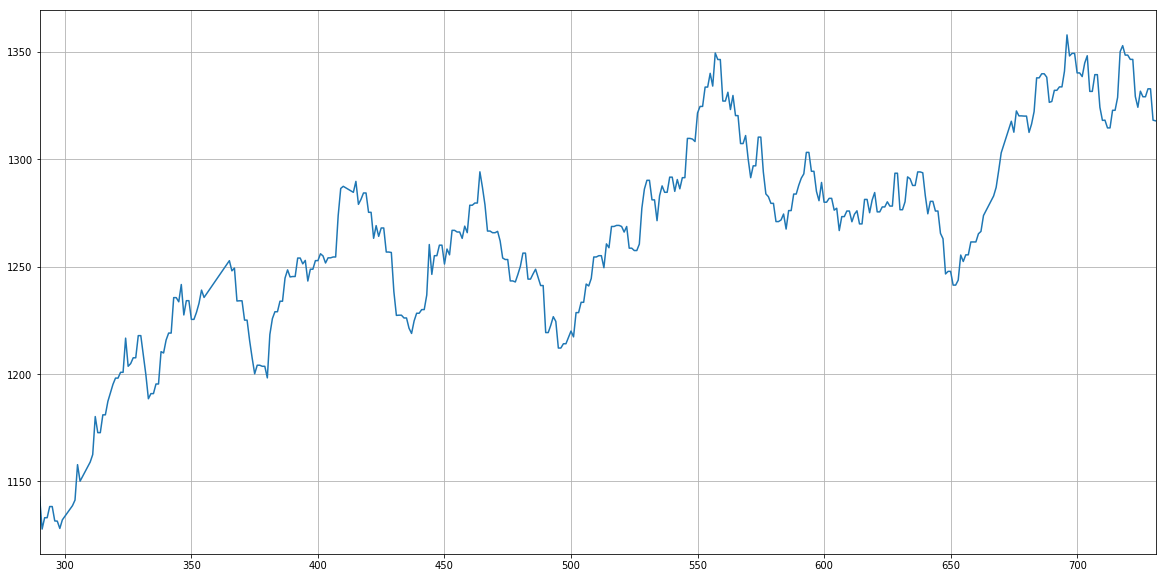

In [82]:
data.plot(figsize=(20, 10), grid=True)
plt.show()

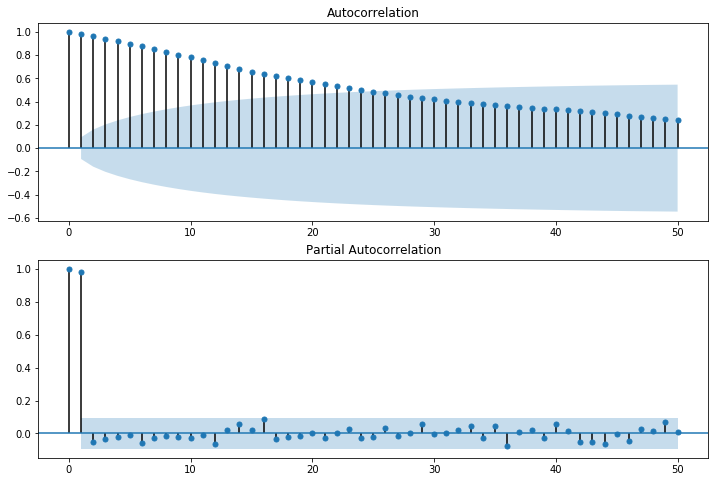

In [83]:
acf_and_pacf(data, lags=50)

# Нормальность Исходных данных

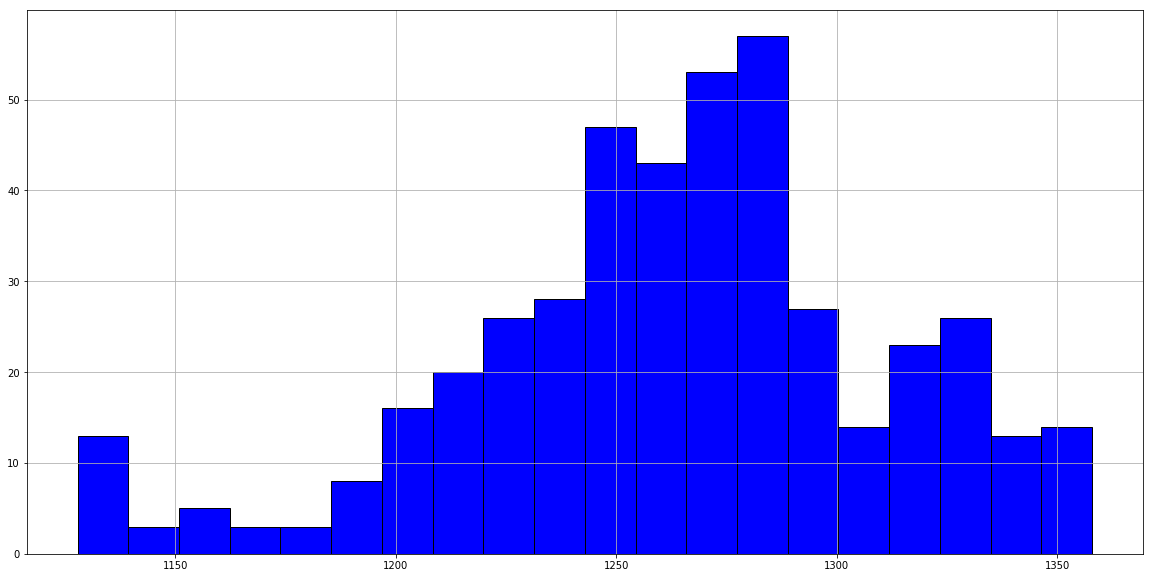

In [84]:
data.hist(figsize=(20, 10), bins=20, color="blue", edgecolor='black')
plt.show()

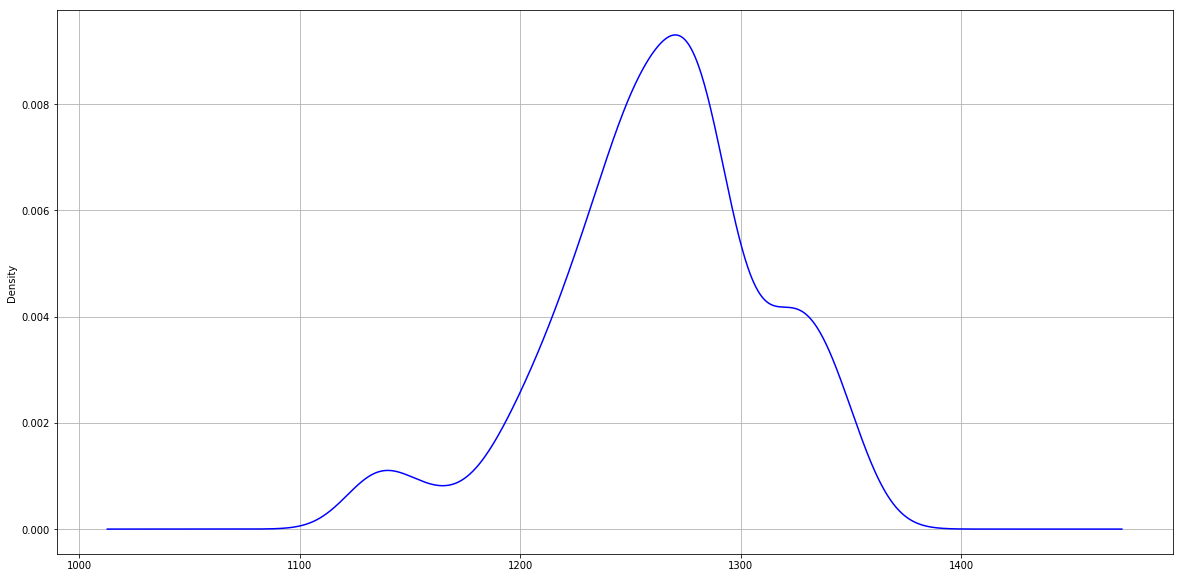

In [85]:
data.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность исходных данных

In [86]:
mann(data)

Группа 1 и 2: 221 и 221
сумма рангов r1 = 27235
сумма рангов r2 = 70668
U = 2704.0
M(U) = 24420.5
D(U) = 1803046.9166666667
Z = -16.1724686972
гипотеза о постоянстве постоянстве мат. ожидания не принимается


In [89]:
sijel(data)

Группа 1 и 2: 221 и 221
сумма рангов r1 = 47905
сумма рангов r2 = 49998
M(U) = -1046.5
D(U) = 1803046.9166666667
Z = -0.778983342112
гипотеза о постоянстве постоянстве дисперсии принимается


# Первые разности

In [90]:
dataR1 = data - data.shift(1)
dataR2 = dataR1 - dataR1.shift(1)

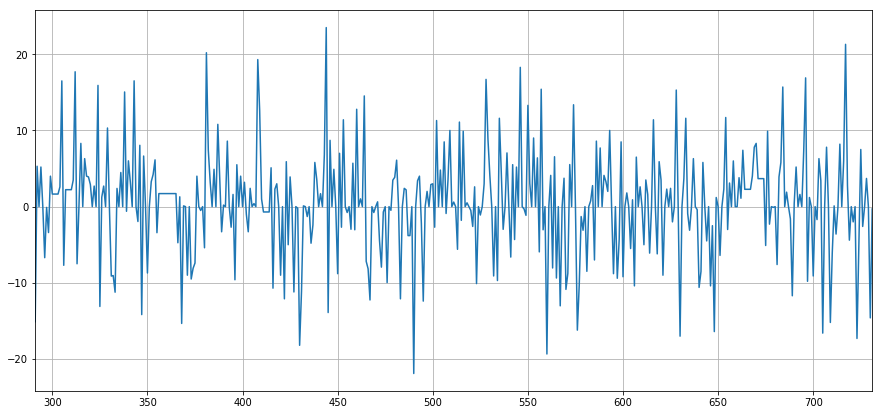

In [91]:
dataR1[1:].plot(figsize=(15,7))
plt.grid()
plt.show()

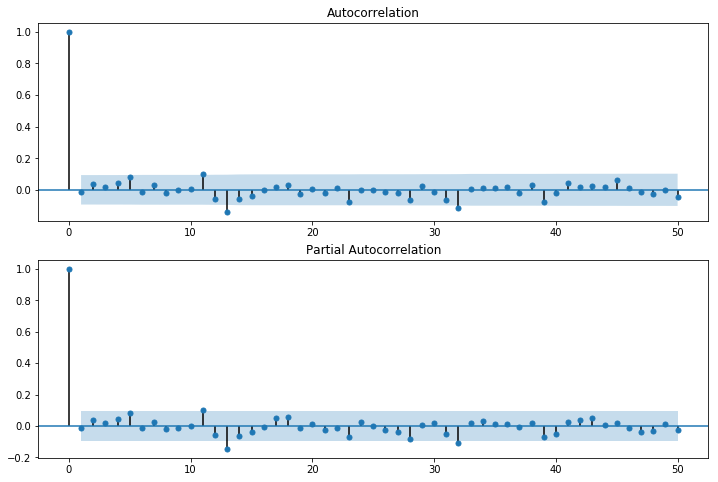

In [92]:
acf_and_pacf(dataR1[1:], lags=50)

In [93]:
stat(dataR1[1:])

счет 441
среднее 0.396825396825
минимальное -21.9 и максимальное 23.5
стандартное отклонение 6.66184633422
дисперсия 44.2795612144
коэффициент вариации 16.7688081132
коэффициент асимметрии -0.040299746488815326
эксцесс 1.3274110564702992


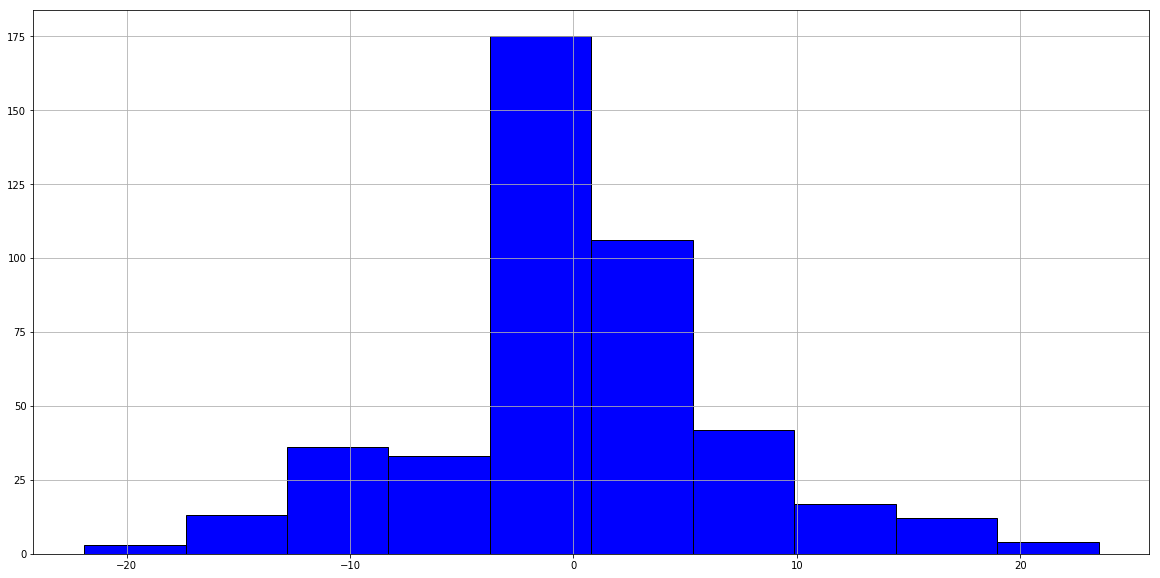

In [94]:
dataR1.hist(figsize=(20,10), bins=10, color="blue", edgecolor='black')
plt.show()

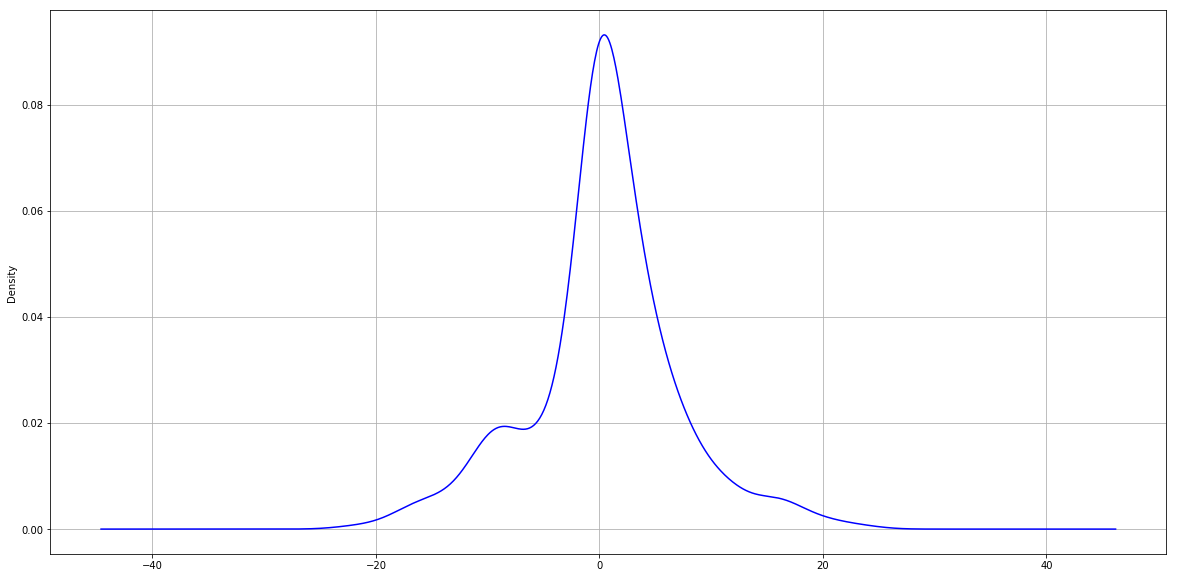

In [95]:
dataR1.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность первых разностей

In [96]:
mann(dataR1[1:])

Группа 1 и 2: 220 и 221
сумма рангов r1 = 47551
сумма рангов r2 = 49910
U = 23241.0
M(U) = 24310.0
D(U) = 1790836.6666666667
Z = -0.798447816541
гипотеза о постоянстве постоянстве мат. ожидания принимается


In [98]:
sijel(dataR1[1:])

Группа 1 и 2: 220 и 221
сумма рангов r1 = 47195
сумма рангов r2 = 50267
M(U) = -1425.0
D(U) = 1790836.6666666667
Z = -1.06447254531
гипотеза о постоянстве постоянстве дисперсии принимается


In [101]:
student2(dataR1[1:])
fisher(dataR1[1:])

дисперсии не равны
критерий Стьюдента = 0.347829205605
критерий Фишера = 1.03811777933


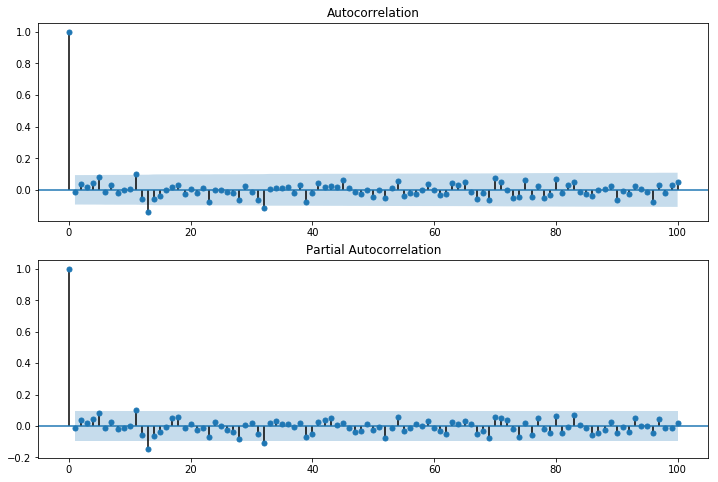

In [102]:
acf_and_pacf(dataR1[1:], lags=100)

# Вторые разности

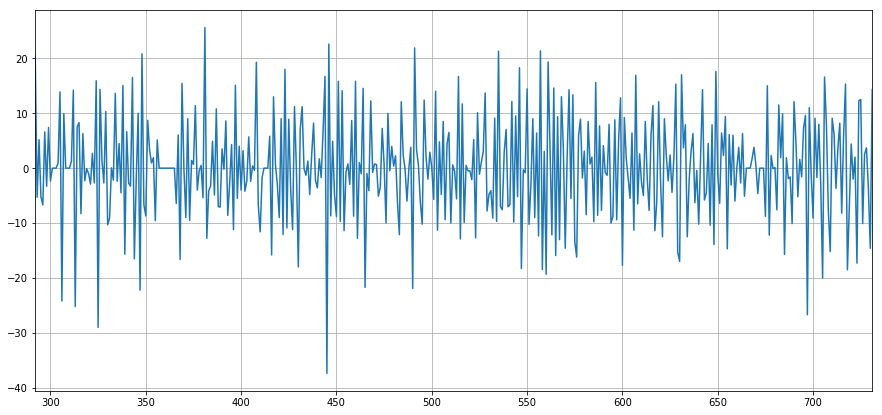

In [103]:
dataR2[2:].plot(figsize=(15,7))
plt.grid()
plt.show()

In [104]:
stat(dataR2[2:])

счет 440
среднее 0.0336363636364
минимальное -37.4 и максимальное 25.6
стандартное отклонение 9.47921419374
дисперсия 89.6512846814
коэффициент вариации 281.494050144
коэффициент асимметрии -0.1736916949757903
эксцесс 0.33137951384213427


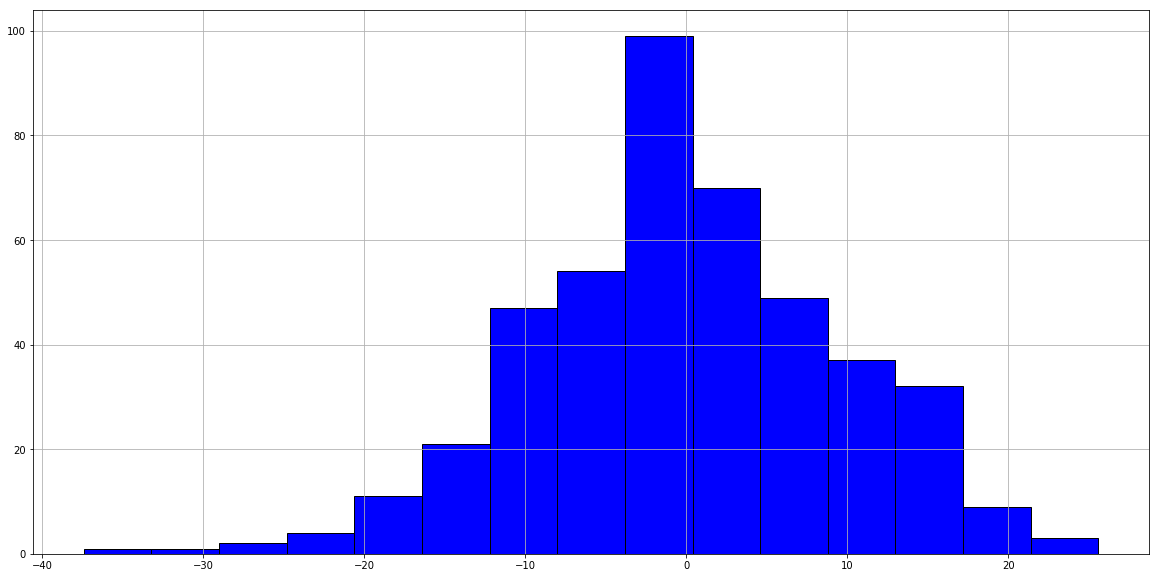

In [105]:
dataR2[2:].hist(figsize=(20,10), bins=15, color="blue", edgecolor='black')
plt.show()

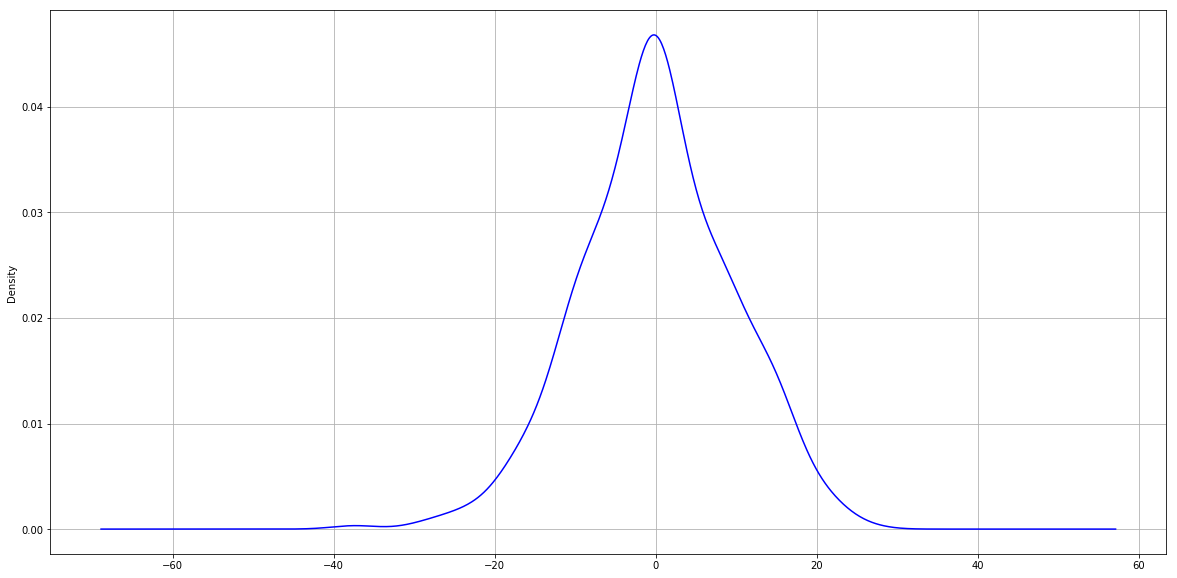

In [106]:
dataR2[2:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность вторых разностей

In [110]:
student2(dataR2[2:])
fisher(dataR2[2:])

дисперсии не равны
критерий Стьюдента = 0.0835808798694
критерий Фишера = 1.00200199744


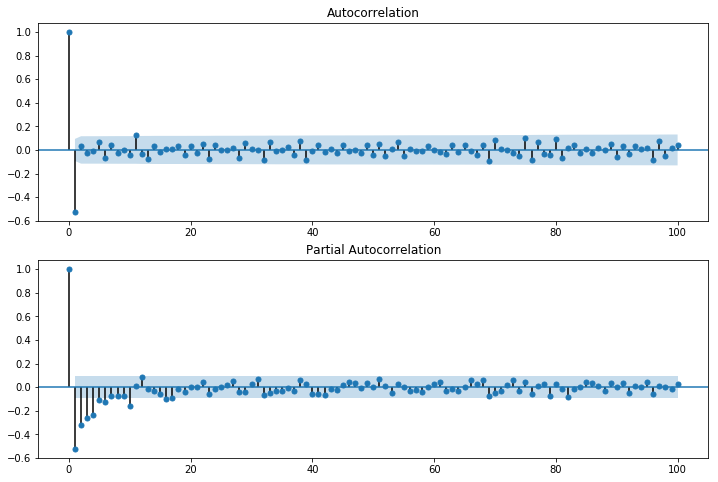

In [111]:
acf_and_pacf(dataR2[2:], lags=100)

# ARIMA

In [113]:
src_data_model = np.array(dataR2[2:])
model = sm.tsa.ARIMA(src_data_model, order=(1,0,0), freq='W').fit(disp=0)
print(model.summary(0.1))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  440
Model:                     ARMA(1, 0)   Log Likelihood               -1542.136
Method:                       css-mle   S.D. of innovations              8.049
Date:                Wed, 27 Jun 2018   AIC                           3090.272
Time:                        00:47:20   BIC                           3102.532
Sample:                             0   HQIC                          3095.109
                                                                              
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
const          0.0063      0.251      0.025      0.980      -0.407       0.419
ar.L1.y       -0.5296      0.041    -12.992      0.000      -0.597      -0.463
                                    Roots           

In [114]:
ar1 = 0.0063 + (2 - 0.5296) * data2.shift(1) - (1 - 2 * 0.5296) * data2.shift(2) - 0.5296 * data2.shift(3)
ost_ar1 = data - ar1

In [115]:
stat(ost_ar1[3:])

счет 439
среднее -0.018453075171
минимальное -28.56198 и максимальное 22.73386
стандартное отклонение 8.02482017432
дисперсия 64.2510469422
коэффициент вариации -434.381532772
коэффициент асимметрии -0.20812951743598013
эксцесс 0.4785435703423233


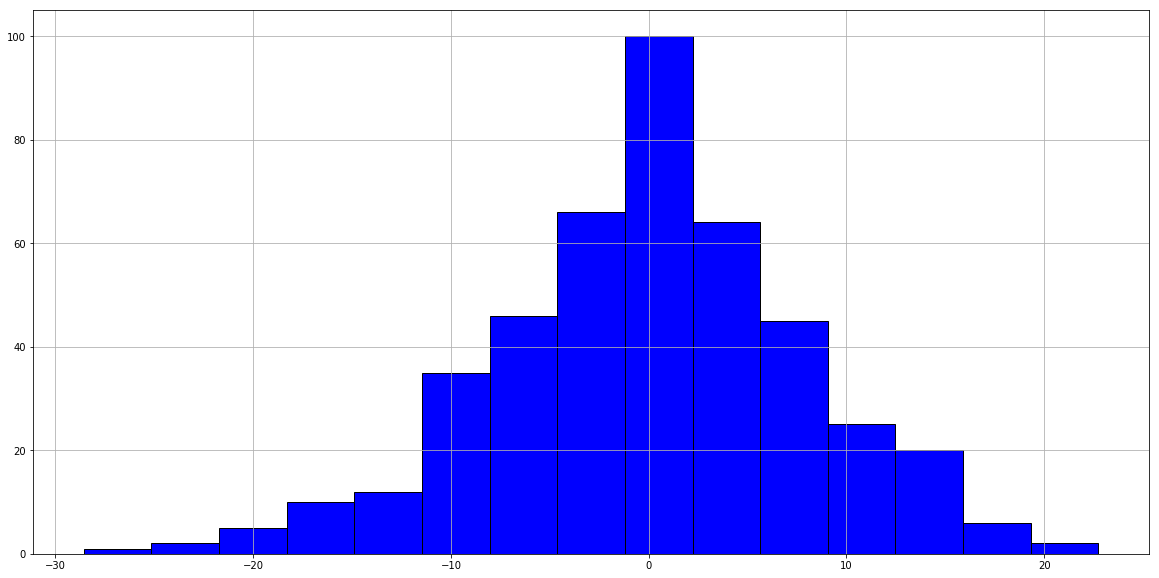

In [116]:
ost_ar1[3:].hist(figsize=(20,10), bins=15, color="blue", edgecolor='black')
plt.show()

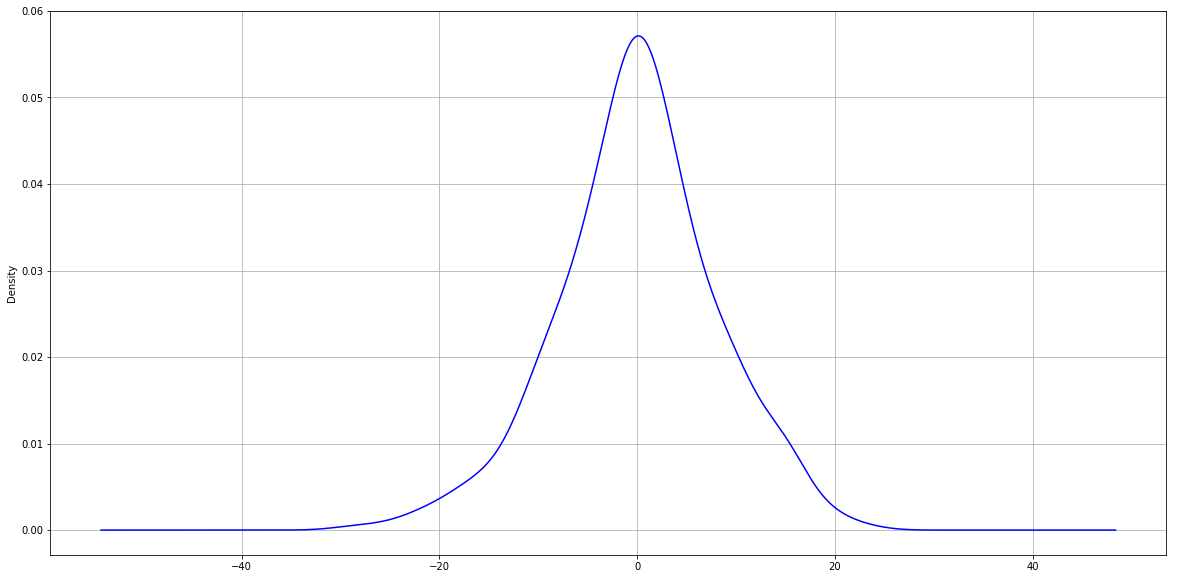

In [117]:
ost_ar1[3:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [118]:
fisher(ost_ar1[3:])

критерий Фишера = 1.14957224404


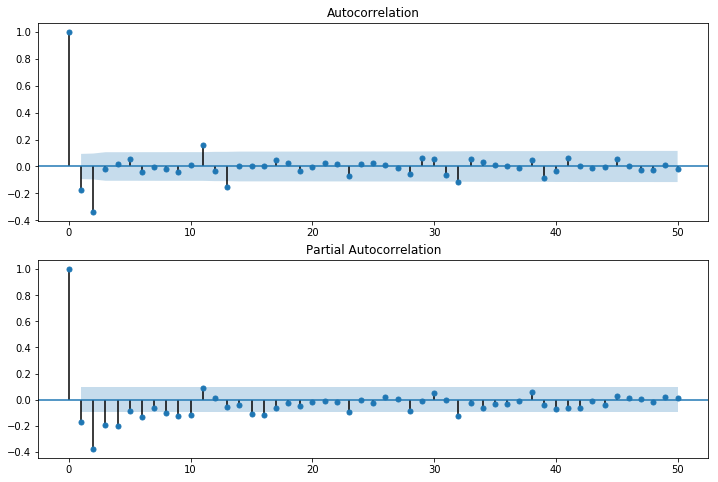

In [119]:
acf_and_pacf(ost_ar1[3:], lags=50)

In [120]:
q_test = sm.tsa.stattools.acf(ost_ar1[3:], qstat=True)
q2 = q_test[0] ** 2
print('Бокс-Пирс', sum(q2[1:]) * 439)
k = 0
j = 1
for i in q2[1:]:
    k = k + i / (439 - j)
    j += 1
print('Льюнг-Бокс', k * 439 * 441)

Бокс-Пирс 112.94892712
Льюнг-Бокс 116.267342358


In [129]:
src_data_model = np.array(ost_kv[3:])
model = sm.tsa.ARIMA(src_data_model, order=(1,2,0), freq='W').fit(disp=0)
print(model.summary(0.1))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  437
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -2878.078
Method:                       css-mle   S.D. of innovations            175.193
Date:                Wed, 27 Jun 2018   AIC                           5762.157
Time:                        00:50:47   BIC                           5774.397
Sample:                             2   HQIC                          5766.987
                                                                              
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
const          0.0649      4.661      0.014      0.989      -7.602       7.732
ar.L1.D2.y    -0.7997      0.029    -27.718      0.000      -0.847      -0.752
                                    Roots           

In [130]:
arima = 0.0649 + (2 - 0.7997) * data2.shift(1) - (1 - 2 * 0.7997) * data2.shift(2) - 0.7997 * data2.shift(3)
ost_arima = data - arima

In [131]:
stat(ost_arima[3:])

счет 439
среднее -0.0767454441913
минимальное -29.30031 и максимальное 22.27141
стандартное отклонение 8.43480583296
дисперсия 70.9838857737
коэффициент вариации -109.781024845
коэффициент асимметрии -0.14521308063490715
эксцесс 0.5033256257254126


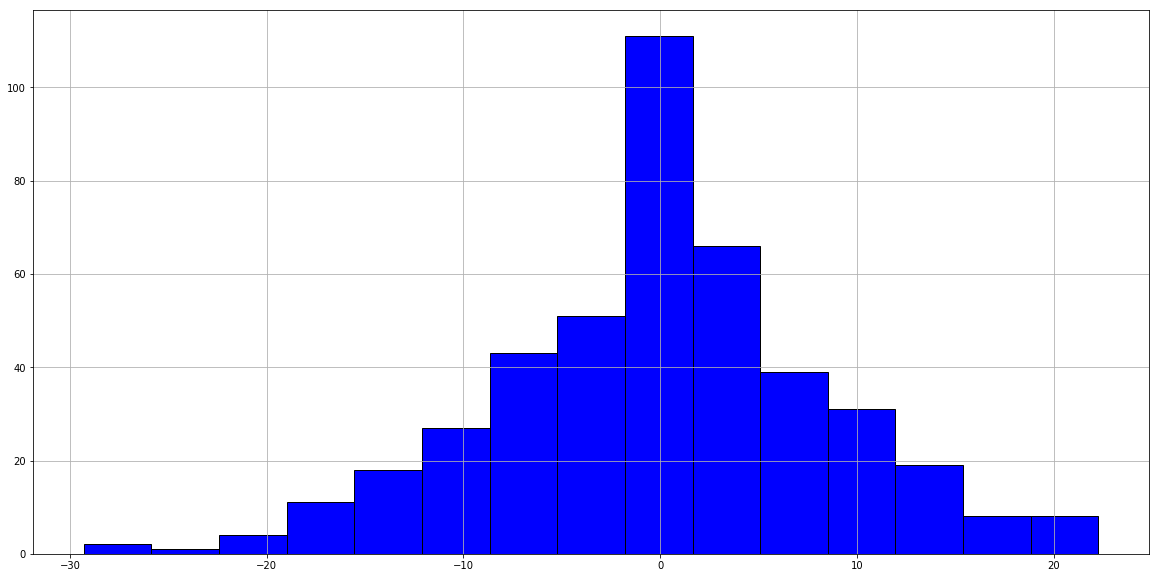

In [132]:
ost_arima[3:].hist(figsize=(20,10), bins=15, color="blue", edgecolor='black')
plt.show()

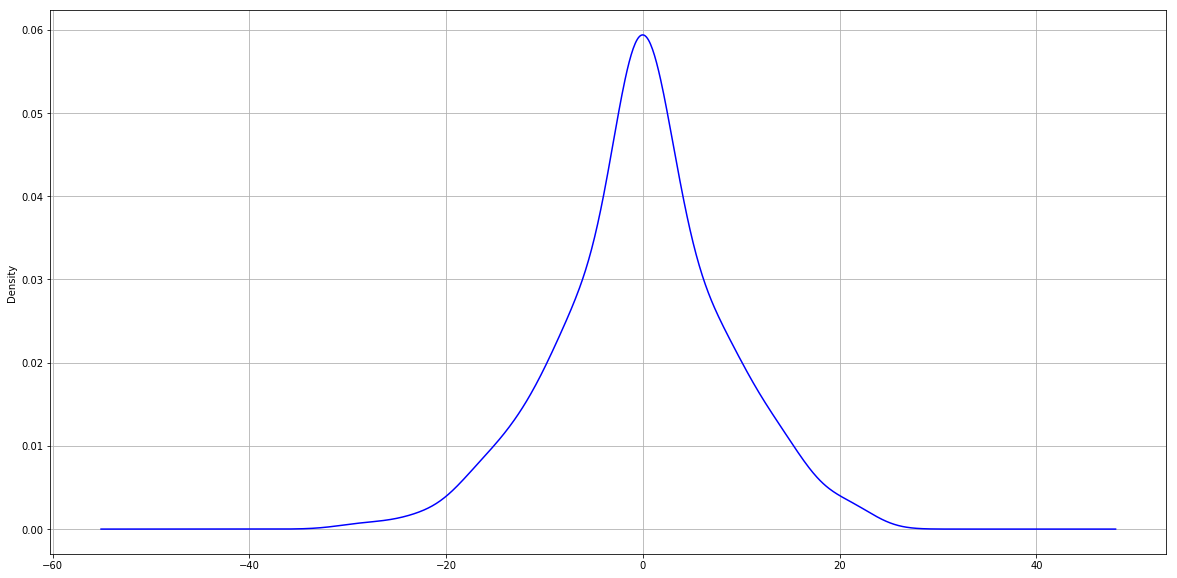

In [133]:
ost_arima[3:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [134]:
fisher(ost_arima[3:])

критерий Фишера = 1.19143740933


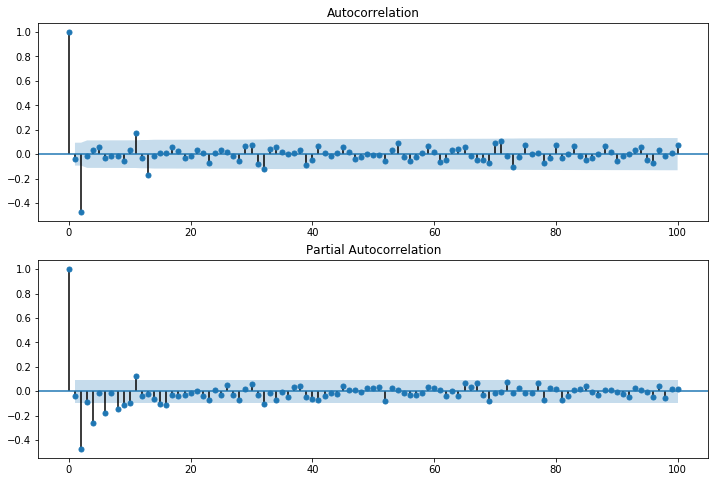

In [135]:
acf_and_pacf(ost_arima[3:], lags=100)

In [136]:
q_test = sm.tsa.stattools.acf(ost_arima[3:], qstat=True)
q2 = q_test[0] ** 2
print('Бокс-Пирс', sum(q2[1:]) * 439)
k = 0
j = 1
for i in q2[1:]:
    k = k + i / (439 - j)
    j += 1
print('Льюнг-Бокс', k * 439 * 441)

Бокс-Пирс 158.119999767
Льюнг-Бокс 162.294254913


In [137]:
ost_kv = ost_arima ** 2

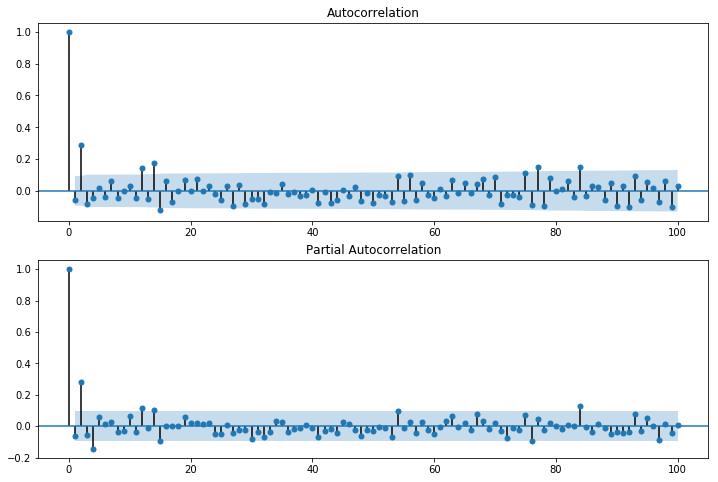

In [138]:
acf_and_pacf(ost_kv[3:], lags=100)